<a href="https://colab.research.google.com/github/Vyoma-garg/Natural-Language-Processing/blob/main/PROJECT_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




> ## **NLP PROJECT WORK BY:**


>------------------------------------


> **Deepshikhar Bhardwaj (M20MA004)**

> **Vyoma Garg (M20MA017)**


>-----------------------------------------


> **Instructor : Dr. Lipika Dey and Dr. Romi Banerjee**





# **Importing Libraries**

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS, WordCloud
from nltk import download
from nltk.corpus import stopwords

In [ ]:
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Getting the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename1 = '/content/drive/MyDrive/text_summarization/news_summary.csv'
filename2 = '/content/drive/MyDrive/text_summarization/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
reviews = df1
print(reviews.shape)
reviews.head()

(4514, 6)


,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking,http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced-labour-trafficking-traning-hotel-staff/1/1017210.html?utm_source=inshorts&u...,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."


In [ ]:
reviews.isnull().sum()

author         0
date           0
headlines      0
read_more      0
text           0
ctext        118
dtype: int64

# **Pre-processing of the data**

In [ ]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [ ]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))

for text in reviews['text']:
    cleaned_text.append(clean_text(text))

In [ ]:
for i in range(4):
    print("Headline: ",i+1) 
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Headline:  1
daman   diu revokes mandatory rakshabandhan in offices order
--------------------------------------------------------------------------------
administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august 7 administration forced withdraw decision within 24 hours issuing circular received flak employees slammed social media

Headline:  2
malaika slams user who trolled her for 'divorcing rich man'
--------------------------------------------------------------------------------
malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing sh know nothing

Headline:  3
'virgin' now corrected to 'unmarried' in igims' form
--------------------------------------------------------------------------------
indira gandhi institute medical sciences igims patna thursd

**Understanding the distribution of the sequences**

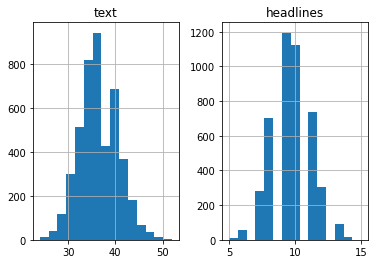

In [ ]:
import matplotlib.pyplot as plt #pip install matplotlib

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

1.0


In [ ]:
max_headlines_len=15
max_text_len=55

In [ ]:
cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

df.head()

,text,headlines
0,administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august 7 administration forced withdraw decision within 24 hours issu...,sostok daman diu revokes mandatory rakshabandhan in offices order eostok
1,malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn fac...,sostok malaika slams user who trolled her for 'divorcing rich man' eostok
2,indira gandhi institute medical sciences igims patna thursday made corrections marital declaration form changing 'virgin' option 'unmarried' earlier bihar health minister defined virgin unmarried ...,sostok 'virgin' now corrected to 'unmarried' in igims' form eostok
3,lashkar e taiba kashmir commander abu dujana killed security forces said kabhi hum aage kabhi aap aaj aapne pakad liya mubarak ho aapko today caught congratulations caught added surrender whatever...,sostok aaj aapne pakad liya let man dujana before being killed eostok
4,hotels maharashtra train staff spot signs sex trafficking including frequent requests bed linen changes 'do disturb' signs left room doors days mobile phone app called rescue allow staff alert pol...,sostok hotel staff to get training to spot signs of sex trafficking eostok


# **Splitting the Dataset into 75% as training and 25% test**

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['headlines']),test_size=0.25,random_state=0,shuffle=True)

# **Preparing Text Tokenizer**

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4  
cnt=0   #number of rare words
tot_cnt=0   # size of the vocabulary 
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data with top most common words    
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

% of rare words in vocabulary: 69.04802597846522
Total Coverage of rare words: 14.516651548529222
5434


# **Preparing Summary Tokenizer**

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=4
cnt=0    #number of rare words
tot_cnt=0    # size of the vocabulary 
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data with top most common words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)

% of rare words in vocabulary: 79.19773720750835
Total Coverage of rare words: 22.19522798762243


(3385, 3385)

# **Deleting the rows with only Start and End tokens**

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# **Creating Attention Layer**

In [ ]:
class AttentionLayer(Layer):


    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# **Creating the Model-1 LSTM + Attention** 

In [ ]:
latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 55, 110)      1337270     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 55, 200), (N 248800      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**Epochs=100, Batch size=32**

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=100,callbacks=[es],batch_size=32, 
                  validation_data=([x_val,y_val[:,:-1]], 
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/100
422/422 [==============================] - 602s 1s/step - loss: 4.6506 - accuracy: 0.3835 - val_loss: 3.9353 - val_accuracy: 0.4419
Epoch 2/100
422/422 [==============================] - 587s 1s/step - loss: 4.0418 - accuracy: 0.4255 - val_loss: 3.7687 - val_accuracy: 0.4560
Epoch 3/100
422/422 [==============================] - 584s 1s/step - loss: 3.8790 - accuracy: 0.4354 - val_loss: 3.6868 - val_accuracy: 0.4603
Epoch 4/100
422/422 [==============================] - 581s 1s/step - loss: 3.7442 - accuracy: 0.4446 - val_loss: 3.5900 - val_accuracy: 0.4666
Epoch 5/100
422/422 [==============================] - 579s 1s/step - loss: 3.6277 - accuracy: 0.4518 - val_loss: 3.5414 - val_accuracy: 0.4699
Epoch 6/100
422/422 [==============================] - 585s 1s/step - loss: 3.5589 - accuracy: 0.4556 - val_loss: 3.4825 - val_accuracy: 0.4755
Epoch 7/100
422/422 [==============================] - 581s 1s/step - loss: 3.4634 - accuracy: 0.4630 - val_loss: 3.4402 - val_accuracy:

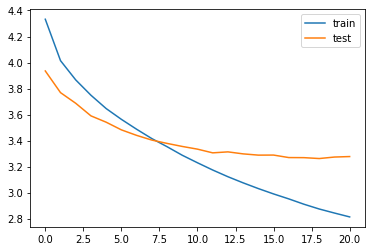

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Inference**

In [ ]:
reverse_target_word_index= y_tokenizer.index_word
reverse_source_word_index= x_tokenizer.index_word
target_word_index= y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## **Generated Summaries**

In [ ]:
for i in range(0,8):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    
    print("\n")

Review: police state mining department tuesday found illegal sand mining taking place greater noida two near yamuna river authorities said recovered around 18 metres sand plot owners booked issued notices worth 70 lakh 
Original summary: illegal sand along yamuna in noida 
Predicted summary:  mumbai arrested for mumbai


Review: england offering nearly 42 000 reward recovery two prize winning stolen agricultural show two stolen along certificates prove prize winning quality could raise value bit like painting stolen said rich 
Original summary: offers 42 000 reward to stolen 
Predicted summary:  delhi police to be held for


Review: completion delhi metro phase iv cleared recently government likely make second largest metro system largest outside china reports said delhi metro currently 11th largest estimated carry 70 lakh people regularly completion phase iv 100 km delhi metro network 
Original summary: delhi metro may become largest metro system outside china 
Predicted summary:  del

# **Creating the Model-2 LSTM + Attention**

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output3, state_h, state_c= encoder_lstm3(encoder_output2)


#encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output4, state_h, state_c= encoder_lstm4(encoder_output3)


#encoder lstm 5
encoder_lstm5=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm5(encoder_output4)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 51, 110)      961840      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 51, 200), (N 248800      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 51, 200), (N 320800      lstm[0][0]                       
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],batch_size=64, 
                  validation_data=([x_val,y_val[:,:-1]], 
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
109/109 [==============================] - 286s 2s/step - loss: 4.0014 - accuracy: 0.4099 - val_loss: 3.8494 - val_accuracy: 0.4324
Epoch 2/50
109/109 [==============================] - 269s 2s/step - loss: 3.8539 - accuracy: 0.4161 - val_loss: 3.7927 - val_accuracy: 0.4349
Epoch 3/50
109/109 [==============================] - 268s 2s/step - loss: 3.7608 - accuracy: 0.4188 - val_loss: 3.7630 - val_accuracy: 0.4372
Epoch 4/50
109/109 [==============================] - 269s 2s/step - loss: 3.6626 - accuracy: 0.4237 - val_loss: 3.7183 - val_accuracy: 0.4399
Epoch 5/50
109/109 [==============================] - 269s 2s/step - loss: 3.5822 - accuracy: 0.4279 - val_loss: 3.6953 - val_accuracy: 0.4397
Epoch 6/50
109/109 [==============================] - 269s 2s/step - loss: 3.4994 - accuracy: 0.4328 - val_loss: 3.6745 - val_accuracy: 0.4414
Epoch 7/50
109/109 [==============================] - 268s 2s/step - loss: 3.4381 - accuracy: 0.4353 - val_loss: 3.6616 - val_accuracy: 0.4417

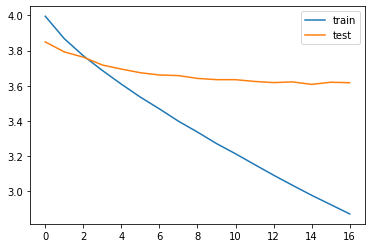

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Inference**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## **Getting Summaries**

In [ ]:
for i in range(0,8):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: india batsman cheteshwar pujara father arvind pujara could see son 373 ball 193 run knock sydney test fly rajkot cardiac procedure mumbai holy family hospital anybody doubt batting cleared i'll go home watch replays arvind said cheteshwar innings 
Original summary: pujara dad could not see his run due to heart 
Predicted summary:  pandya will not be to be in australia


Review: 'the gandhi film based mahatma gandhi assassination release india certain elements issued threats film producer lakshmi r iyer said indians sensitive learn truth clearly time lakshmi said film set release worldwide january 30 mahatma gandhi death anniversary 
Original summary: 'the gandhi india release cancelled due to threats 
Predicted summary:  i have not want to be sara on


Review: iit madras hostel allegedly put details student caught used inside room notice board list also included names students along items found rooms calling violation privacy students alleged hostel officials rooms clicked pict

#**Creating the Model-3 BiLSTM +Attention**

In [ ]:
from keras import backend as K 
from keras.layers import Bidirectional



K.clear_session()


latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(8456,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_bi_lstm1 = Bidirectional(LSTM(latent_dim,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.4,
                                   recurrent_dropout=0.4), 
                                 merge_mode="concat")
encoder_output1, forward_state_h1, forward_state_c1, backward_state_h1, backward_state_c1 = encoder_bi_lstm1(enc_emb)
encoder_states1 = [forward_state_h1, forward_state_c1, backward_state_h1, backward_state_c1]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
#decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

decoder_bi_lstm = Bidirectional(LSTM(latent_dim, 
                                  return_sequences=True, 
                                  return_state=True,
                                  dropout=0.4,
                                  recurrent_dropout=0.2),
                             merge_mode="concat")
decoder_outputs, decoder_fwd_state_h1, decoder_fwd_state_c1, decoder_back_state_h1, decoder_back_state_c1 = decoder_bi_lstm(dec_emb,initial_state=encoder_states1)
decoder_states = [decoder_fwd_state_h1, decoder_fwd_state_c1, decoder_back_state_h1, decoder_back_state_c1]

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_output1, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 
####################################################################################
####################################################################################
####################################################################################

dec_h_state_f = tf.keras.layers.Input(shape=(latent_dim))
dec_h_state_r = tf.keras.layers.Input(shape=(latent_dim))

dec_c_state_f = tf.keras.layers.Input(shape=(latent_dim))
dec_c_state_r = tf.keras.layers.Input(shape=(latent_dim))


# Create the hidden input layer with twice the latent dimension,
# since we are using bi - directional LSTM's we will get 
# two hidden states and two cell states

dec_hidden_inp = tf.keras.layers.Input(shape=(8456, latent_dim * 2))

dec_model = tf.keras.models.Model([decoder_inputs] + [dec_hidden_inp, dec_h_state_f, dec_h_state_r, dec_c_state_f, dec_c_state_r],
                              [decoder_outputs] + [decoder_back_state_h1])



In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],batch_size=64, 
                  validation_data=([x_val,y_val[:,:-1]], 
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Inference**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

## **Getting summaries**

In [ ]:
for i in range(0,8):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

# **MODEL-4: Evaluation with Larger Dataset with 50 EPOCHS**

## **Getting the Dataset**

In [ ]:
reviews = df2[:15000]
print(reviews.shape)
reviews.head()

(15000, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."


In [ ]:
data = df2[:15000]

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  15000 non-null  object
 1   text       15000 non-null  object
dtypes: object(2)
memory usage: 351.6+ KB


## **Pre-processing of the data**

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
cleaned_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [ ]:
#call the function
cleaned_summary = []
for t in data['headlines']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:10]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam',
 'rahat fateh ali khan denies getting notice for smuggling currency',
 'india get all out for their lowest odi total in new zealand',
 'govt directs alok verma to join work day before his retirement',
 'called pm modi sir times to satisfy his ego andhra cm',
 'cong wins ramgarh bypoll in rajasthan takes total to seats']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

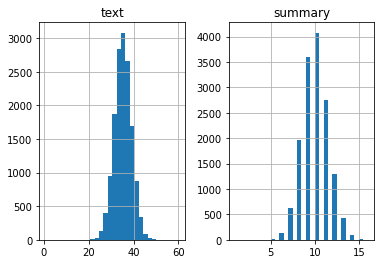

In [ ]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9998666666666667


In [ ]:
max_text_len=55
max_summary_len=15

In [ ]:

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## **Splitting the dataset in 90% Training and 10% test**

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

## **Preparing Text Tokenizer**

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 61.269355763716305
Total Coverage of rare words: 6.157800180704832


In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

12157

## **Preparing Summary Tokenizer**

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.15595075239399
Total Coverage of rare words: 12.725733634311512


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(13497, 13497)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## **Creating the model**

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 100)      1215700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,
                  callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]],
                                                                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
27/27 [==============================] - 504s 19s/step - loss: 4.2411 - accuracy: 0.4207 - val_loss: 4.0599 - val_accuracy: 0.4360
Epoch 2/50
27/27 [==============================] - 498s 18s/step - loss: 4.1366 - accuracy: 0.4222 - val_loss: 3.9695 - val_accuracy: 0.4412
Epoch 3/50
27/27 [==============================] - 503s 19s/step - loss: 4.0518 - accuracy: 0.4238 - val_loss: 3.9280 - val_accuracy: 0.4397
Epoch 4/50
27/27 [==============================] - 495s 18s/step - loss: 3.9884 - accuracy: 0.4248 - val_loss: 3.8430 - val_accuracy: 0.4471
Epoch 5/50
27/27 [==============================] - 554s 20s/step - loss: 3.9193 - accuracy: 0.4260 - val_loss: 3.8217 - val_accuracy: 0.4418
Epoch 6/50
27/27 [==============================] - 494s 18s/step - loss: 3.8509 - accuracy: 0.4273 - val_loss: 3.7408 - val_accuracy: 0.4501
Epoch 7/50
27/27 [==============================] - 496s 18s/step - loss: 3.7907 - accuracy: 0.4293 - val_loss: 3.7379 - val_accuracy: 0.4480
Epoch 

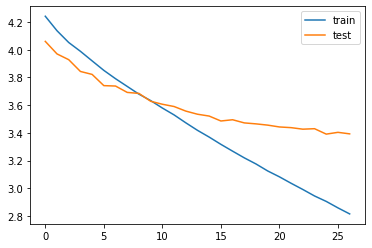

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Inference**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
!pip install rouge

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge 
rouge_score = Rouge()

## **Getting summaries with evaluation metrics**

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    scorer = rouge_score.get_scores(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    #scores = scorer.score(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print('ROUGE SCORE ', scorer)
    bleu_score = sentence_bleu( seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)) )
    print('BLEU SCORE ', bleu_score)
   # F1 = 2 * (bleu_score * scorer) / (bleu_score + scorer)
   # print('F1 Score ', F1)
    print("\n")


Review: shiv sena chief uddhav thackeray took dig bjp government saying solve issues farmers first talk coalition addressing maharashtra drought hit farmers added want drought end permanently end political drought shiv sena said government letting farmers get anything 
Original summary: farmers issues then talk about coalition sena to bjp 
Predicted summary:  aap is to bring to sabha lok sabha sena
ROUGE SCORE  [{'rouge-1': {'f': 0.22222221722222232, 'p': 0.2222222222222222, 'r': 0.2222222222222222}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.12499999507812519, 'p': 0.1111111111111111, 'r': 0.14285714285714285}}]
BLEU SCORE  0.7691605673134586


Review: bengaluru based ride hailing startup ola reportedly offered billion investment japanese conglomerate softbank owns around stake reports said ceo aggarwal may accept offer current form may give softbank stake previous reports claimed africa largest conglomerate naspers may invest ola billion valuation 
Original summary

# **MODEL-5: Evaluation with Larger Dataset with 100 Epochs**

## **Getting the Dataset**

In [ ]:
reviews = df2[:15000]
print(reviews.shape)
reviews.head()

(15000, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."


In [ ]:
data = df2[:15000]

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  15000 non-null  object
 1   text       15000 non-null  object
dtypes: object(2)
memory usage: 351.6+ KB


## **Preprocessing tha data**

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))

In [ ]:
cleaned_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [ ]:
#call the function
cleaned_summary = []
for t in data['headlines']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:10]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam',
 'rahat fateh ali khan denies getting notice for smuggling currency',
 'india get all out for their lowest odi total in new zealand',
 'govt directs alok verma to join work day before his retirement',
 'called pm modi sir times to satisfy his ego andhra cm',
 'cong wins ramgarh bypoll in rajasthan takes total to seats']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

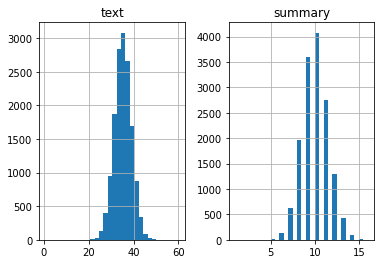

In [ ]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9998666666666667


In [ ]:
max_text_len=55
max_summary_len=15

In [ ]:

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## **Splitting the dataset into 90% Training and 10% Test**

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

## **Text Tokenization**

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 61.269355763716305
Total Coverage of rare words: 6.157800180704832


In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

12157

## **Summary Tokenization**

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.15595075239399
Total Coverage of rare words: 12.725733634311512


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(13497, 13497)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## **Creating the model**

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 100)      1215700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100,
                  callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]],
                                                                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/100
27/27 [==============================] - 509s 18s/step - loss: 5.7963 - accuracy: 0.2922 - val_loss: 4.3648 - val_accuracy: 0.3824
Epoch 2/100
27/27 [==============================] - 499s 18s/step - loss: 4.5388 - accuracy: 0.3586 - val_loss: 4.2302 - val_accuracy: 0.4279
Epoch 3/100
27/27 [==============================] - 503s 19s/step - loss: 4.3753 - accuracy: 0.3967 - val_loss: 4.1153 - val_accuracy: 0.4406
Epoch 4/100
27/27 [==============================] - 498s 18s/step - loss: 4.2755 - accuracy: 0.4161 - val_loss: 4.0287 - val_accuracy: 0.4406
Epoch 5/100
27/27 [==============================] - 503s 19s/step - loss: 4.1667 - accuracy: 0.4195 - val_loss: 3.9584 - val_accuracy: 0.4421
Epoch 6/100
27/27 [==============================] - 501s 19s/step - loss: 4.0757 - accuracy: 0.4229 - val_loss: 3.9077 - val_accuracy: 0.4452
Epoch 7/100
27/27 [==============================] - 500s 18s/step - loss: 4.0066 - accuracy: 0.4241 - val_loss: 3.8713 - val_accuracy: 0.4450

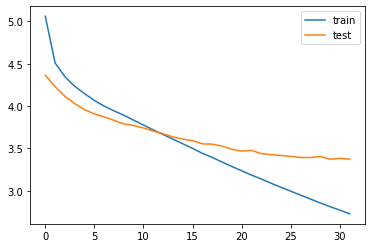

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Inference**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
!pip install rouge

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge 
rouge_score = Rouge()

## **Getting Summaries and Evaluation metrics**

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    scorer = rouge_score.get_scores(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    #scores = scorer.score(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print('ROUGE SCORE ', scorer)
    bleu_score = sentence_bleu( seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)) )
    print('BLEU SCORE ', bleu_score)
   # F1 = 2 * (bleu_score * scorer) / (bleu_score + scorer)
   # print('F1 Score ', F1)
    print("\n")



Review: shiv sena chief uddhav thackeray took dig bjp government saying solve issues farmers first talk coalition addressing maharashtra drought hit farmers added want drought end permanently end political drought shiv sena said government letting farmers get anything 
Original summary: farmers issues then talk about coalition sena to bjp 
Predicted summary:  will not be to be of sena
ROUGE SCORE  [{'rouge-1': {'f': 0.24999999507812506, 'p': 0.2222222222222222, 'r': 0.2857142857142857}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.1333333285333335, 'p': 0.1111111111111111, 'r': 0.16666666666666666}}]
BLEU SCORE  0.8065008590125561


Review: bengaluru based ride hailing startup ola reportedly offered billion investment japanese conglomerate softbank owns around stake reports said ceo aggarwal may accept offer current form may give softbank stake previous reports claimed africa largest conglomerate naspers may invest ola billion valuation 
Original summary: softbank offe